**Illustration of usage of selection functions in the context of producing "synthetic observations" from a model (in this case, a model for the density distribution of stars in the Galaxy)**

* Notebook contrbuted by Eugene Vasiliev
* Depens on [agama](https://github.com/GalacticDynamics-Oxford/Agama)

In [2]:
import numpy, agama, time, matplotlib, matplotlib.pyplot as plt
# work in "standard Galactic units": 1 kpc, 1 km/s, 1 Msun
agama.setUnits(length=1, velocity=1, mass=1)
# disable built-in OpenMP parallelization (it would not work with user-defined Python functions anyway)
agama.setNumThreads(1)
# create a fiducial density profile which combines elements of disk and halo populations
dens = agama.Density(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)

common routine for plotting the sampled stars in the face-on & edge-on Galactocentric views, a heliocentric sky view, and the distributions of absolute & apparent magnitudes and distance moduli.

In [3]:
def projectMollweide(lon, lat):
    ang = numpy.array(lat)
    bla = numpy.pi/2 * numpy.sin(lat)
    w = (1 - abs(ang) * 2/numpy.pi)**(2./3)
    ang = (1 - w * (1 + (1-w) * (-0.09 - 0.086*w) )) * numpy.sign(ang) * numpy.pi/2
    for it in range(3):
        ang -= 0.5 * (ang + 0.5*numpy.sin(2*ang) - bla) / numpy.cos(ang)**2
    X = lon * 2/numpy.pi * numpy.cos(ang)
    Y = numpy.sin(ang)
    return X, Y

def show(xyz, M_G=None):
    plt.figure(figsize=(12.8,4.8))
    ax=[plt.axes([0.06,0.06,0.24,0.64]), plt.axes([0.06,0.72,0.24,0.24]),
        plt.axes([0.31,0.55,0.33,0.44]), plt.axes([0.31,0.09,0.33,0.44])]
    l,b,d = agama.getGalacticFromGalactocentric(*xyz.T)
    distmod = 5*numpy.log10(d/0.01)
    p,q = projectMollweide(l,b)
    gridx = numpy.linspace(-32,32,257)
    gridz = numpy.linspace(-12,12,97)
    gridp = numpy.linspace(-2, 2, 361)
    gridq = numpy.linspace(-1, 1, 181)
    histxy = numpy.histogram2d(xyz[:,0], xyz[:,1], bins=(gridx,gridx))[0]
    histxz = numpy.histogram2d(xyz[:,0], xyz[:,2], bins=(gridx,gridz))[0]
    histpq = numpy.histogram2d(p, q, bins=(gridp,gridq))[0]
    ax[0].imshow(5*numpy.log10(histxy.T+1), extent=(min(gridx),max(gridx),min(gridx),max(gridx)), origin='lower',
        interpolation='nearest', cmap='hell_r', vmin=0, vmax=20)
    ax[1].imshow(5*numpy.log10(histxz.T+1), extent=(min(gridx),max(gridx),min(gridz),max(gridz)), origin='lower',
        interpolation='nearest', cmap='hell_r', vmin=0, vmax=20)
    ax[2].imshow(5*numpy.log10(histpq.T+1), extent=(-2,2,-1,1), origin='lower', interpolation='nearest',
        cmap='hell_r', vmin=0, vmax=20)
    ax[2].add_artist(matplotlib.patches.Ellipse((0,0), 4, 2, fill=False, color='k', lw=0.5, clip_on=False))
    ax[0].set_xlim(min(gridx), max(gridx)); ax[0].set_ylim(min(gridx), max(gridx))
    ax[1].set_xlim(min(gridx), max(gridx)); ax[1].set_ylim(min(gridz), max(gridz)); ax[1].set_xticklabels([])
    ax[2].set_xlim(2,-2); ax[2].set_ylim(-1,1); ax[2].set_axis_off()
    ax[3].set_xlim(2,-2); ax[3].set_ylim(-1,1); ax[3].set_axis_off()
    if M_G is not None:
        Gmag = M_G + distmod
        histpqG = numpy.histogram2d(p, q, bins=(gridp,gridq), weights=Gmag)[0]
        ax[3].imshow(histpqG.T/(histpq.T+1e-10), extent=(-2,2,-1,1), origin='lower', interpolation='nearest',
            cmap='earth_r', vmin=17, vmax=22)
        ax[3].add_artist(matplotlib.patches.Ellipse((0,0), 4, 2, fill=False, color='k', lw=0.5, clip_on=False))
        ax[3].set_xlim(-2,2); ax[2].set_ylim(-1,1); ax[2].set_axis_off()
        plt.axes([0.42,0.06,0.11,0.02])
        plt.imshow(numpy.linspace(0,1,128).reshape(1,-1), extent=[17,22,0,1], aspect='auto', interpolation='nearest',
            cmap='earth_r', vmin=0, vmax=1)
        plt.xlim(17,22); plt.xlabel('mean G'); plt.gca().set_yticks([])
        plt.axes([0.69,0.06,0.30,0.90])
        gridm = numpy.linspace(-5,25,301)
        plt.hist(M_G,     bins=gridm, histtype='step', label='absolute mag')
        plt.hist(Gmag,    bins=gridm, histtype='step', label='apparent mag')
        plt.hist(distmod, bins=gridm, histtype='step', label='dist.modulus')
        plt.xlim(min(gridm), max(gridm)); plt.yscale('log')
        plt.xlabel('magnitude')
        plt.ylabel('number of stars')
        plt.legend(loc='lower right')

sample 1 million points from the density profile without applying any selection function, using the built-in method of `agama.Density` class.

Sampling of 1000000 points took 3.6 seconds, total mass of stars 4.997e+10 Msun


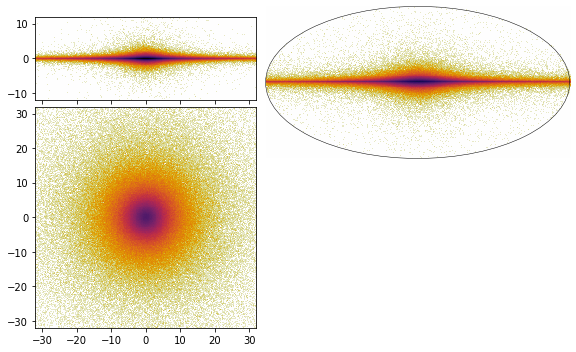

In [4]:
t0 = time.time()
xyz,m = dens.sample(1000000)
t1 = time.time()
show(xyz)
print('Sampling of %i points took %.1f seconds, total mass of stars %.4g Msun' % (len(xyz), t1-t0, numpy.sum(m)))

For more complicated sampling exercises, we will need to use heliocentric coordinates and write our own function (probability distribution to sample from) to be provided to the general N-dimensional sampling routine.

In [5]:
help(agama.sampleNdim)

Help on built-in function sampleNdim in module agama.agama:

sampleNdim(...)
    Sample from a non-negative N-dimensional function.
    Draw a requested number of points from the hypercube in such a way that the density of points at any location is proportional to the value of function.
    Arguments:
      fnc - a callable object that must accept a single argument (a 2d array MxN array of coordinates, where N is the dimension of the hypercube, and M>=1 is the number of points where the function should be evaluated simultaneously -- this improves performance), and return a 1d array of M non-negative values (one for each point), interpreted as the probability density;
      nsamples - the required number of samples drawn from this function;
      lower, upper - two arrays of the same length (equal to the number of dimensions) that specify the lower and upper boundaries of the region (hypercube) to be sampled; alternatively, a single value - the number of dimensions - may be passed inste

The first thing that we need is to augment the spatial dimensions (two sky-plane coordinates and distance modulus) with the fourth dimension - the absolute magnitude of stars, taken for simplicity from a single-age, single-metallicity isochrone.

Text(0, 0.5, 'number of stars')

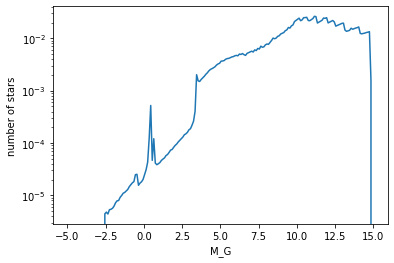

In [6]:
gridM_G = numpy.linspace(-5, 15, 201)
# luminosity function (number of stars per bin in M_G)
gridLF  = numpy.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.44e-6, 4.79e-6, 4.41e-6, 5.33e-6, 5.43e-6, 5.67e-6, 6.22e-6, 7.21e-6, 7.87e-6, 7.98e-6, 9.17e-6, 9.96e-6, 1.10e-5, 1.14e-5, 1.22e-5, 1.30e-5, 1.47e-5, 1.60e-5, 1.74e-5, 1.83e-5, 2.49e-5, 2.53e-5, 1.56e-5, 1.72e-5, 1.82e-5, 2.02e-5, 2.49e-5, 3.10e-5, 4.32e-5, 1.23e-4, 5.22e-4, 4.67e-5, 1.21e-4, 4.13e-5, 3.86e-5, 4.02e-5, 4.24e-5, 4.66e-5, 4.94e-5, 5.20e-5, 5.77e-5, 6.04e-5, 6.62e-5, 7.33e-5, 7.54e-5, 8.29e-5, 9.02e-5, 9.59e-5, 1.05e-4, 1.13e-4, 1.22e-4, 1.30e-4, 1.44e-4, 1.50e-4, 1.60e-4, 1.79e-4, 1.88e-4, 2.19e-4, 2.62e-4, 4.03e-4, 2.02e-3, 1.54e-3, 1.50e-3, 1.64e-3, 1.76e-3, 1.88e-3, 2.05e-3, 2.19e-3, 2.39e-3, 2.54e-3, 2.63e-3, 2.73e-3, 2.86e-3, 3.08e-3, 3.24e-3, 3.33e-3, 3.66e-3, 3.69e-3, 3.76e-3, 3.99e-3, 4.10e-3, 4.14e-3, 4.26e-3, 4.41e-3, 4.47e-3, 4.64e-3, 4.72e-3, 4.64e-3, 5.01e-3, 4.92e-3, 5.12e-3, 4.87e-3, 4.72e-3, 5.16e-3, 5.33e-3, 5.50e-3, 5.68e-3, 5.48e-3, 6.01e-3, 5.84e-3, 6.41e-3, 6.24e-3, 7.08e-3, 6.74e-3, 6.89e-3, 7.51e-3, 7.79e-3, 7.68e-3, 8.38e-3, 9.09e-3, 1.01e-2, 9.82e-3, 1.01e-2, 1.09e-2, 1.12e-2, 1.21e-2, 1.25e-2, 1.29e-2, 1.40e-2, 1.45e-2, 1.61e-2, 1.57e-2, 1.73e-2, 1.80e-2, 2.09e-2, 2.20e-2, 2.31e-2, 2.43e-2, 2.17e-2, 2.25e-2, 2.48e-2, 2.49e-2, 2.52e-2, 2.19e-2, 2.17e-2, 2.27e-2, 2.38e-2, 2.63e-2, 2.60e-2, 1.96e-2, 2.04e-2, 2.12e-2, 2.21e-2, 2.44e-2, 2.41e-2, 2.48e-2, 1.97e-2, 2.04e-2, 2.11e-2, 2.19e-2, 2.06e-2, 1.71e-2, 1.76e-2, 1.81e-2, 1.87e-2, 1.93e-2, 1.95e-2, 1.44e-2, 1.36e-2, 1.39e-2, 1.42e-2, 1.56e-2, 1.49e-2, 1.53e-2, 1.57e-2, 1.60e-2, 1.65e-2, 1.24e-2, 1.22e-2, 1.24e-2, 1.26e-2, 1.29e-2, 1.31e-2, 1.34e-2, 1.59e-3, 0, 0])
plt.plot((gridM_G[1:]+gridM_G[:-1])/2, gridLF[:-1])
plt.yscale('log')
plt.xlabel('M_G')
plt.ylabel('number of stars')

First repeat the exercise of sampling from the entire density distribution (without any cutoff on apparent magnitude), but now using heliocentric coordinates: l, sin(b), distance modulus. The value of the density profile is multiplied by the Jacobian of conversion from these coords to the 3d spatial coordinates.

In [7]:
def samplefnc_all(data):
    l, sinb, distmod = data.T
    b = numpy.arcsin(sinb)
    dist = 10**(0.2*distmod-2)
    jac  = dist**3 * 0.2*numpy.log(10)
    xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
    return dens.density(xyz) * jac

Sampling of 1000000 points took 5.2 seconds, total mass of stars 4.981e+10 Msun


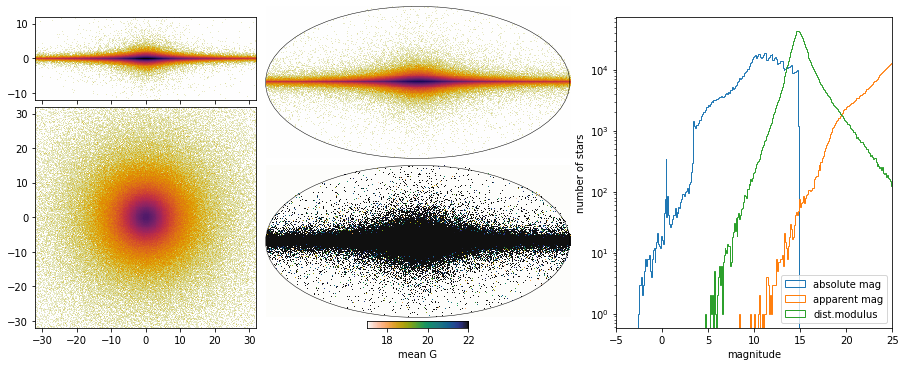

In [8]:
t0 = time.time()
data,mtot = agama.sampleNdim(samplefnc_all, 1000000, [-numpy.pi, -1, -5.0], [numpy.pi, +1, 25.0])[0:2]
t1 = time.time()
# sample the absolute magnitude from the isochrone, using the inverse of the cumulative distribution function
M_G = numpy.interp(numpy.random.random(len(data)), numpy.hstack((0, numpy.cumsum(gridLF[:-1])/sum(gridLF))), gridM_G)
l, sinb, distmod = data.T
b = numpy.arcsin(sinb)
dist = 10**(0.2*distmod-2)
xyz = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
show(xyz, M_G)
print('Sampling of %i points took %.1f seconds, total mass of stars %.4g Msun' % (len(xyz), t1-t0, mtot))

The above result is (nearly) equivalent to sampling from rho(X,Y,Z) directly.

Since we did not provide a magnitude cutoff, the vast majority of stars in the sample are way too faint to be actually observed.

Now perform the sampling with a cutoff at G=21 (probability density is zero beyond this apparent magnitude).

In [9]:
def samplefnc_lf(data):
    l, sinb, distmod, M_G = data.T
    b = numpy.arcsin(sinb)
    binG = numpy.searchsorted(gridM_G, M_G)
    dist = 10**(0.2*distmod-2)
    gmag = distmod + M_G
    jac  = dist**3 * 0.2*numpy.log(10)
    xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
    return dens.density(xyz) * jac * gridLF[binG] * (gmag < 21.0)

Sampling of 1000000 points took 10.0 seconds, total number of stars 4.632e+08


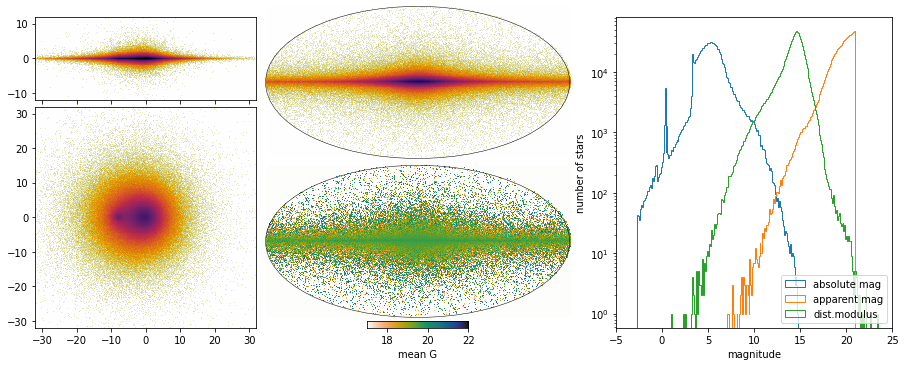

In [10]:
t0=time.time()
data,mtot = agama.sampleNdim(samplefnc_lf, 1000000, [-numpy.pi, -1, -5.0, -5.0], [numpy.pi, +1, 25.0, 15.0])[0:2]
t1=time.time()
l, sinb, distmod, M_G = data.T
b = numpy.arcsin(sinb)
dist = 10**(0.2*distmod-2)
xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
show(xyz, M_G)
print('Sampling of %i points took %.1f seconds, total number of stars %.4g' % (len(data), t1-t0, mtot))

Now use a more realistic selection function from Tristan: the probability density is multiplied by `S(l,b,Gmag)`.

In [11]:
import gaiaunlimited.selectionfunctions, astropy.coordinates, astropy.units
dr3sf = gaiaunlimited.selectionfunctions.DR3SelectionFunctionTCG_hpx7()

/usr/local/lib/python3.7/site-packages/astropy/config/configuration.py:532: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Intended Astropy directory /Users/user/.astropy is actually a file. on None
  warn(ConfigurationMissingWarning(msg))


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [12]:
def samplefnc_lf_sf(data):
    l, sinb, distmod, M_G = data.T
    b = numpy.arcsin(sinb)
    binG = numpy.searchsorted(gridM_G, M_G)
    dist = 10**(0.2*distmod-2)
    gmag = distmod + M_G
    jac  = dist**3 * 0.2*numpy.log(10)
    xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
    coo  = astropy.coordinates.SkyCoord(l=l * astropy.units.radian, b=b * astropy.units.radian, frame='galactic')
    completeness = dr3sf.query(coo, gmag)
    return dens.density(xyz) * jac * gridLF[binG] * completeness

Sampling of 10000 points took 32.6 seconds, total number of stars 4.499e+08


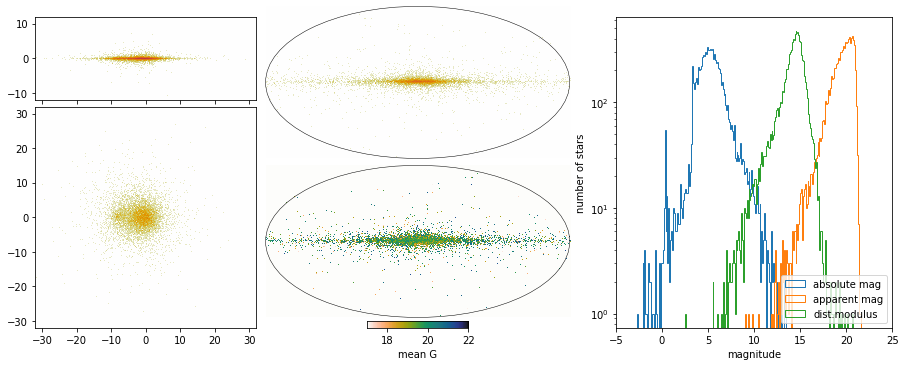

In [13]:
t0=time.time()
data,mtot = agama.sampleNdim(samplefnc_lf_sf, 10000, [-numpy.pi, -1, -5.0, -5.0], [numpy.pi, +1, 25.0, 15.0])[0:2]
t1=time.time()
l, sinb, distmod, M_G = data.T
b = numpy.arcsin(sinb)
dist = 10**(0.2*distmod-2)
xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
show(xyz, M_G)
print('Sampling of %i points took %.1f seconds, total number of stars %.4g' % (len(data), t1-t0, mtot))

This all works fine, but is very slow for some unknown reason. To speed it up, I manually call the relevant functions (conversion from l,b to the healpix index, querying Tristan's map of the M10 parameter, and converting the M10 value to the completeness function).

In [14]:
import healpy
def samplefnc_lf_sf2(data):
    l, sinb, distmod, M_G = data.T
    b = numpy.arcsin(sinb)
    binG = numpy.searchsorted(gridM_G, M_G)
    dist = 10**(0.2*distmod-2)
    gmag = distmod + M_G
    jac  = dist**3 * 0.2*numpy.log(10)
    xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
    pixind = healpy.pixelfunc.ang2pix(2**7, numpy.pi/2-b, l, nest=True)
    m10 = dr3sf.m10map[:,2][pixind]
    completeness = gaiaunlimited.selectionfunctions.m10_to_completeness(gmag, m10)
    return dens.density(xyz) * jac * gridLF[binG] * completeness

Sampling of 1000000 points took 12.0 seconds, total number of stars 4.8e+08


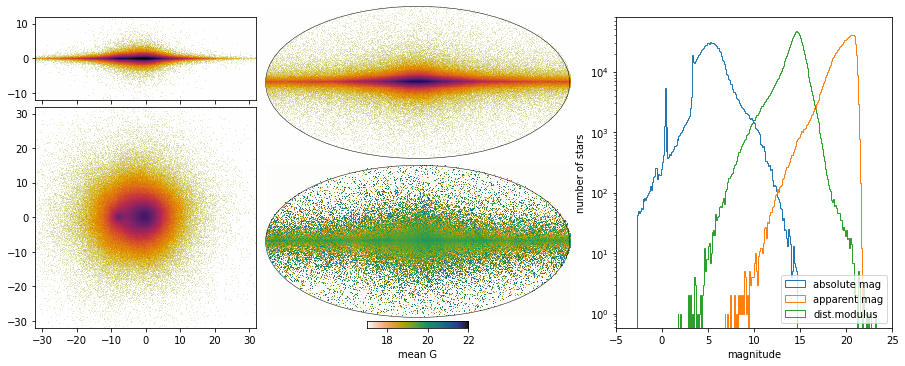

In [15]:
t0=time.time()
data,mtot = agama.sampleNdim(samplefnc_lf_sf2, 1000000, [-numpy.pi, -1, -5.0, -5.0], [numpy.pi, +1, 25.0, 15.0])[0:2]
t1=time.time()
l, sinb, distmod, M_G = data.T
b = numpy.arcsin(sinb)
dist = 10**(0.2*distmod-2)
xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
show(xyz, M_G)
print('Sampling of %i points took %.1f seconds, total number of stars %.4g' % (len(data), t1-t0, mtot))

Now repeat this exercise with an addition of extinction (for simplicity, using the 2d SFD map, not a distance-dependent 3d extinction map). The extinction value in the G band at the given sky point is added to the apparent G magnitude before computing the completeness factor.

In [16]:
import dustmaps.sfd
sfd = dustmaps.sfd.SFDQuery()
def samplefnc_lf_sf2_dust(data):
    l, sinb, distmod, M_G = data.T
    b = numpy.arcsin(sinb)
    binG = numpy.searchsorted(gridM_G, M_G)
    dist = 10**(0.2*distmod-2)
    coo  = astropy.coordinates.SkyCoord(l=l * astropy.units.radian, b=b * astropy.units.radian, frame='galactic')
    A_G  = sfd.query(coo) * 2.3
    gmag = distmod + M_G + A_G
    jac  = dist**3 * 0.2*numpy.log(10)
    xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
    pixind = healpy.pixelfunc.ang2pix(2**7, numpy.pi/2-b, l, nest=True)
    m10 = dr3sf.m10map[:,2][pixind]
    completeness = gaiaunlimited.selectionfunctions.m10_to_completeness(gmag, m10)
    return dens.density(xyz) * jac * gridLF[binG] * completeness

Sampling of 100000 points took 45.2 seconds, total number of stars 7.253e+07


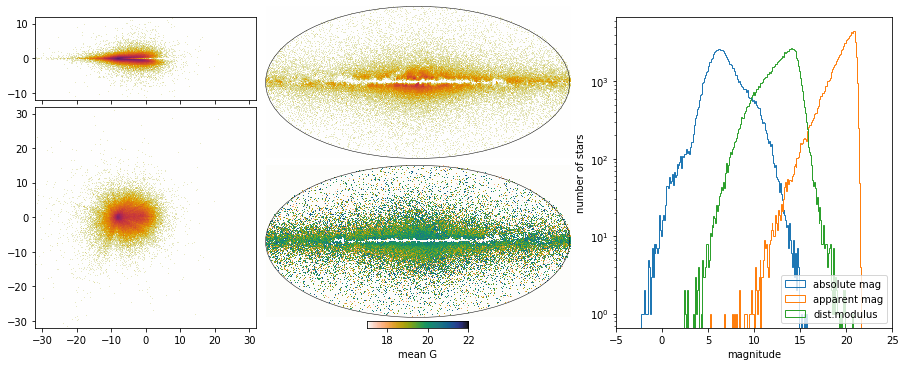

In [17]:
t0=time.time()
data,mtot = agama.sampleNdim(samplefnc_lf_sf2_dust, 100000, [-numpy.pi, -1, -5.0, -5.0], [numpy.pi, +1, 25.0, 15.0])[0:2]
t1=time.time()
l, sinb, distmod, M_G = data.T
b = numpy.arcsin(sinb)
dist = 10**(0.2*distmod-2)
xyz  = numpy.column_stack(agama.getGalactocentricFromGalactic(l, b, dist))
coo  = astropy.coordinates.SkyCoord(l=l * astropy.units.radian, b=b * astropy.units.radian, frame='galactic')
M_G += sfd.query(coo) * 2.3 
show(xyz, M_G)
print('Sampling of %i points took %.1f seconds, total number of stars %.4g' % (len(data), t1-t0, mtot))